# Model implementation

The model that performed best was XGBoost on fold no. 2.  So we need to preprocess the test data then implement the model.

In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prince import MCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

In [2]:
# Load the test data and the correct fold for training
with open("raw_data/dtypes.json", "r") as file:
    dtypes = json.load(file)
df_test = pd.read_csv("raw_data/exp_test.csv", dtype=dtypes)
df_test = df_test.iloc[:, :-1]
df_train_final = pd.read_csv("raw_data/exp_train.csv", dtype=dtypes)

In [3]:
# Impute `GarageYrBlt`
yr_impute = SimpleImputer(strategy="constant", fill_value=0)
df_test.loc[:, "GarageYrBlt"] = pd.DataFrame(
    yr_impute.fit_transform(df_test[["GarageYrBlt"]])
)

In [4]:
# Preprocessing pipelines for the numerical features
num_med_cols = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "BsmtFullBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "YrSold",
]
num_mode_cols = [
    "LandSlope",
    "LotShape",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "HeatingQC",
    "KitchenQual",
    "GarageFinish",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "Fence",
    "PoolQC",  # (ordinals)
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "BsmtHalfBath",
    "KitchenAbvGr",
    "GarageYrBlt",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
]
len_num_cols = len(num_med_cols) + len(num_mode_cols)
pipe_num_med = Pipeline([("impute", SimpleImputer(strategy="median"))])
pipe_num_mode = Pipeline([("impute", KNNImputer())])

In [5]:
# Preprocessing for categorical features
cat_cols = (
    df_train_final.select_dtypes(include="object")
    .drop(columns=["Id"])
    .columns.to_list()
)

# OHE
ohe = OneHotEncoder(handle_unknown="ignore")
id_tf = df_train_final["Id"]
id_test = df_test["Id"]
ohe_transformed_tf = pd.DataFrame(ohe.fit_transform(df_train_final[cat_cols]).toarray())
ohe_transformed_test = pd.DataFrame(ohe.transform(df_test[cat_cols]).toarray())
prices_tf = df_train_final["SalePrice"]
cols1 = num_med_cols + num_mode_cols
cols2 = ohe_transformed_tf.columns.to_list()
cols3 = ["SalePrice"]
df_train_final = pd.concat(
    [
        id_tf.reset_index(drop=True),
        df_train_final[cols1].reset_index(drop=True),
        ohe_transformed_tf.reset_index(drop=True),
        prices_tf.reset_index(drop=True),
    ],
    axis=1,
    ignore_index=True,
)
df_train_final.columns = ["Id"] + cols1 + [str(x) for x in cols2] + cols3
df_test = pd.concat(
    [
        id_test.reset_index(drop=True),
        df_test[cols1].reset_index(drop=True),
        ohe_transformed_test.reset_index(drop=True),
    ],
    axis=1,
    ignore_index=True,
)
df_test.columns = ["Id"] + cols1 + [str(x) for x in cols2]
new_cat_cols = [str(x) for x in cols2]

# Make the cat cols pipeline
pipe_cat = MCA(n_components=len(new_cat_cols) - 1, one_hot=False)

In [6]:
# Run the pipelines (tried ColumnTransformer and it was problematic)
tf_num_med_transf = pd.DataFrame(
    pipe_num_med.fit_transform(df_train_final[num_med_cols])
)
test_num_med_transf = pd.DataFrame(
    pipe_num_med.transform(df_train_final[num_med_cols])
).reset_index(drop=True)

tf_num_mode_transf = pd.DataFrame(
    pipe_num_mode.fit_transform(df_train_final[num_mode_cols])
)
test_num_mode_transf = pd.DataFrame(
    pipe_num_mode.transform(df_test[num_mode_cols])
).reset_index(drop=True)

tf_cat_tranf = pd.DataFrame(pipe_cat.fit_transform(df_train_final[new_cat_cols]))
test_cat_tranf = pd.DataFrame(pipe_cat.transform(df_test[new_cat_cols])).reset_index(
    drop=True
)

df_train_final = pd.concat(
    [
        df_train_final["Id"],
        tf_num_med_transf,
        tf_num_mode_transf,
        tf_cat_tranf,
        df_train_final["SalePrice"],
    ],
    axis=1,
)
df_test = pd.concat(
    [df_test["Id"], test_num_med_transf, test_num_mode_transf, test_cat_tranf],
    axis=1,
    ignore_index=True,
).iloc[:1459, :]

In [7]:
# Determine the number of components to keep from MCA
exp_var = 0.8
eigenvalues = pipe_cat.eigenvalues_
total_inertia = eigenvalues.sum()
evr_list = eigenvalues / total_inertia
exp_var_sum = 0
n_comp = 0
for j in range(len(evr_list)):
    exp_var_sum = exp_var_sum + evr_list[j]
    if exp_var_sum <= exp_var:
        n_comp += 1
    else:
        break

# Cut the extraneous features in the categorical dataframe
n_cols = 1 + len_num_cols + n_comp
df_train_final = df_train_final.iloc[:, list(range(n_cols)) + [-1]]
df_train_final.columns = (
    ["Id"] + num_med_cols + num_mode_cols + list(range(n_comp)) + ["SalePrice"]
)
df_test = df_test.iloc[:, list(range(n_cols))]
df_test.columns = ["Id"] + num_med_cols + num_mode_cols + list(range(n_comp))

In [8]:
# Fit the model
xgradboost = XGBRegressor()
xgradboost.fit(df_train_final.iloc[:, 1:-1], df_train_final.iloc[:, -1])
y_pred = xgradboost.predict(df_test.iloc[:, 1:])

In [9]:
# Export the result to a file
submission = pd.DataFrame({"Id": df_test["Id"], "SalePrice": y_pred})
submission.to_csv("submission.csv", index=False)

Check the distribution of the solution:

count      1459.000000
mean     177952.453125
std       64794.980469
min       52734.128906
25%      134942.703125
50%      165217.625000
75%      205268.984375
max      553456.937500
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

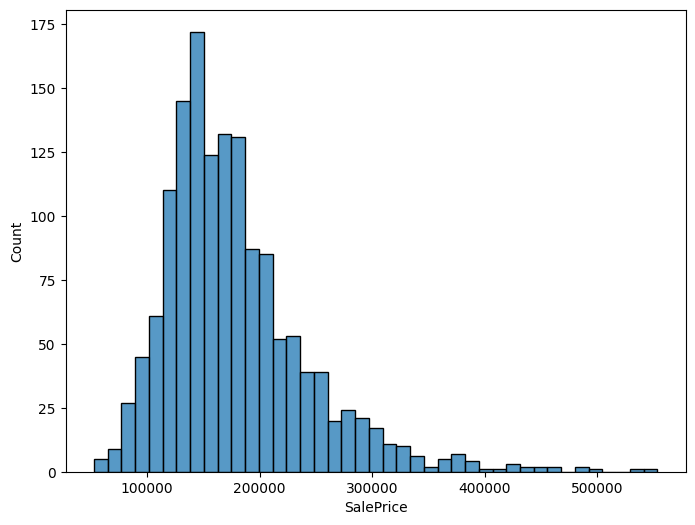

In [10]:
print(submission["SalePrice"].describe())
plt.figure(figsize=(8, 6))
sns.histplot(submission["SalePrice"])